In [223]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional, concatenate, Flatten, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, auc
from sklearn.metrics import roc_curve
from tensorflow.keras.models import Model

# Звгрузка датасета и деление на выборки

In [260]:
df = pd.read_csv('/kaggle/working/01.06_update_dataset.csv', sep="\t")


# разделяем данные на текстовые, числовые признаки и метки
X_text = df['Text Content'].values
X_numeric = df[['url_length', 'num_subdomains', 'has_hyphen',
                'has_https', 'domain_length', 'phishing_keywords_in_url',
                'phishing_keywords_in_text', 'text_length']].values
y = df['Label'].values

# преобразуем текст в последовательности чисел
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=200)

# нормализуем числовые признаки
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)

# кодируем метки
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [225]:
# настраиваем кросс-валидцию
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []
roc_auc_scores = []
all_histories = []
all_models = []

# начинаем обучение на каждом фолде
for fold, (train_idx, test_idx) in enumerate(kfold.split(X_pad, y)):
    print(f"\n{'='*50}\nFold {fold + 1}\n{'='*50}")
    
    # разделяем данные на обучающую и тестовую
    X_train_text, X_test_text = X_pad[train_idx], X_pad[test_idx]
    X_train_num, X_test_num = X_numeric[train_idx], X_numeric[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    
    # вычисляем веса классов для балансировки
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    # создаем модель нейросети и вход для текста
    text_input = Input(shape=(200,), name='text_input')
    embedding = Embedding(input_dim=10000, output_dim=128, trainable=False)(text_input)
    conv1 = Conv1D(128, 5, activation='relu')(embedding)
    pool1 = MaxPooling1D(5)(conv1)
    conv2 = Conv1D(128, 5, activation='relu')(pool1)
    pool2 = MaxPooling1D(5)(conv2)
    lstm = Bidirectional(LSTM(128))(pool2)
    
    # вход для числовых признаков
    num_input = Input(shape=(X_numeric.shape[1],), name='num_input')
    dense_num = Dense(128, activation='relu')(num_input)
    
    # объединяем оба входа
    merged = concatenate([lstm, dense_num])
    dropout = Dropout(0.2)(merged)
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout)
    output = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=[text_input, num_input], outputs=output)
    
    # настраиваем оптимизатор и компилируем модель
    optimizer = AdamW(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # добавляем callback
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    # обучаем модель
    history = model.fit(
        [X_train_text, X_train_num], y_train,
        epochs=70,
        batch_size=64,
        validation_data=([X_test_text, X_test_num], y_test),
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    # сохраняем модель и историю обучения
    all_models.append(model)
    all_histories.append(history)

    # делаем предсказания и вычисляем метрики
    y_pred = model.predict([X_test_text, X_test_num])
    y_pred_classes = (y_pred > 0.5).astype(int)

    f1 = f1_score(y_test, y_pred_classes)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    # выводим отчет по классификации
    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(y_test, y_pred_classes))
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")

# выводим итоговые результаты по всем фолдам
print("\n" + "="*50)
print("Final Results")
print("="*50)
print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Average ROC AUC Score: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")

# находим лучшую модель
best_fold_idx = np.argmax(f1_scores)
print(f"\nBest fold is {best_fold_idx + 1} with F1-score: {f1_scores[best_fold_idx]:.4f}")


Fold 1
Epoch 1/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5579 - loss: 1.7780 - val_accuracy: 0.8953 - val_loss: 1.7014 - learning_rate: 1.0000e-04
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7796 - loss: 1.7038 - val_accuracy: 0.9070 - val_loss: 1.6349 - learning_rate: 1.0000e-04
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8379 - loss: 1.6409 - val_accuracy: 0.9302 - val_loss: 1.5690 - learning_rate: 1.0000e-04
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8599 - loss: 1.5763 - val_accuracy: 0.8837 - val_loss: 1.5042 - learning_rate: 1.0000e-04
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8643 - loss: 1.5186 - val_accuracy: 0.8953 - val_loss: 1.4349 - learning_rate: 1.0000e-04
Epoch 6/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8568 - loss: 1.4411 - val_accuracy: 0.8372 - val_loss: 1.3652 - learning_rate: 1.0000e-04
Epoch 7/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy:

In [226]:
# функция для отображения истории обученя
def plot_training_history(history, fold):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold + 1} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Тhe best fold:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


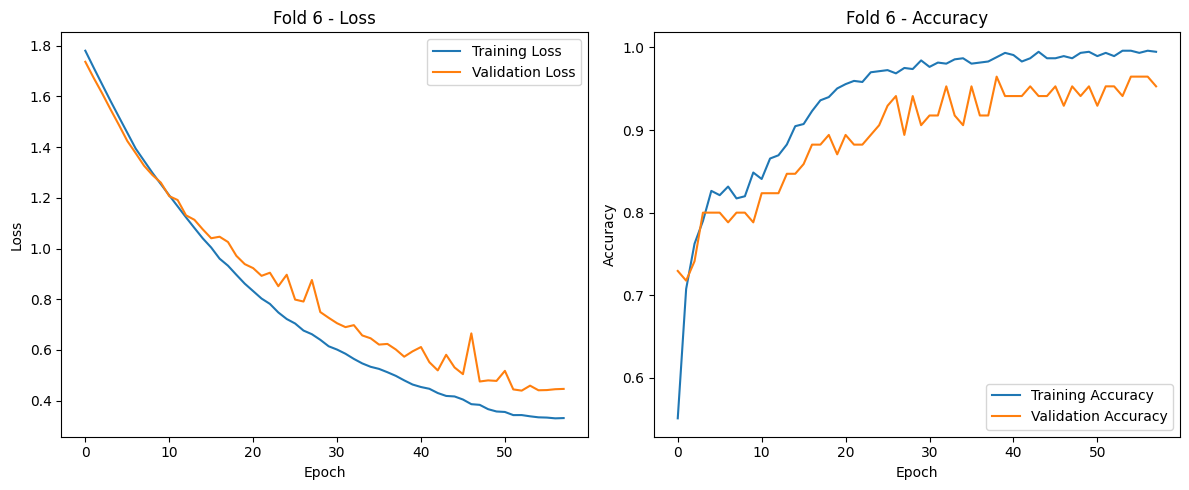

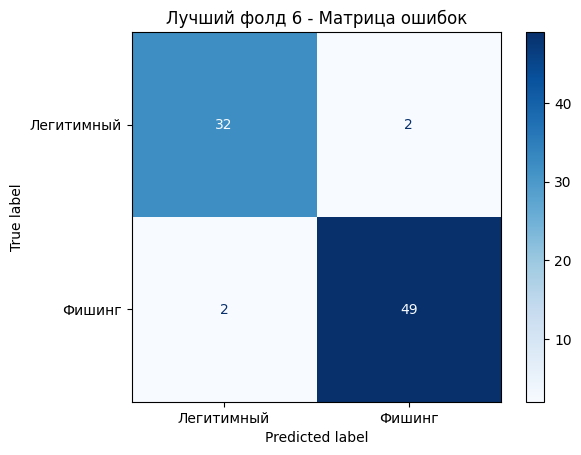

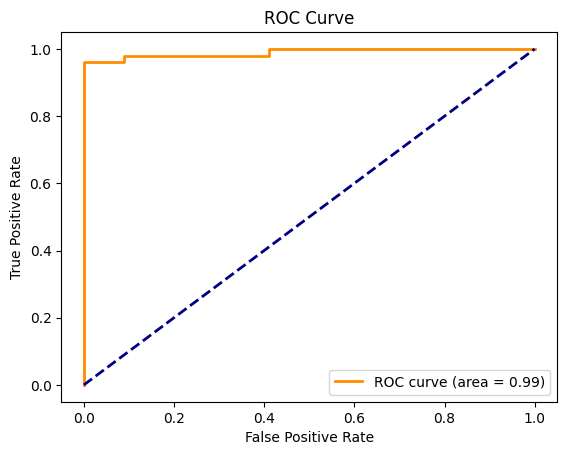

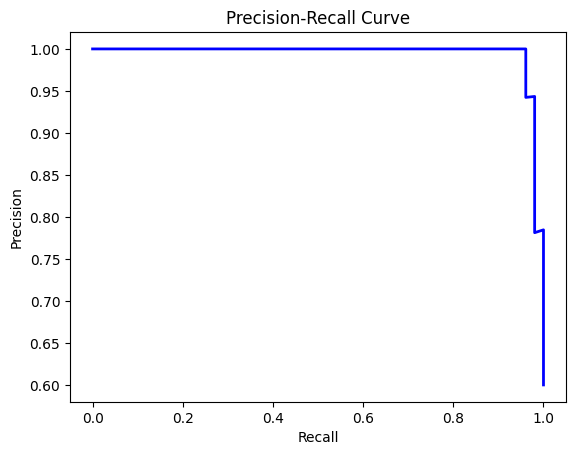

In [227]:
# анализируем лучшую модель
print("\nТhe best fold:")
best_model = all_models[best_fold_idx]
best_history = all_histories[best_fold_idx]

_, test_idx = list(kfold.split(X_pad, y))[best_fold_idx]
X_test_text_best = X_pad[test_idx]
X_test_num_best = X_numeric[test_idx]
y_test_best = y[test_idx]

y_pred_best = best_model.predict([X_test_text_best, X_test_num_best])
y_pred_classes_best = (y_pred_best > 0.5).astype(int)

# выводим графики обучения для лучшей моделм
plot_training_history(best_history, best_fold_idx)

# выводим confmatrix
cm = confusion_matrix(y_test_best, y_pred_classes_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Легитимный', 'Фишинг'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Лучший фолд {best_fold_idx + 1} - Матрица ошибок')
plt.show()

# выводим ROC-кривую
fpr, tpr, _ = roc_curve(y_test_best, y_pred_best)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# выводим precision-recall кривую
precision, recall, _ = precision_recall_curve(y_test_best, y_pred_best)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()



In [229]:
# анализ важности признаков
print("\nАнализ важности признаков:")
#  Важность слов из Embedding слоя
embedding_layer = best_model.layers[1]
embedding_weights = embedding_layer.get_weights()[0]
word_importance = np.linalg.norm(embedding_weights, axis=1)


word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in word_index.items()}

# ттоп-10 важных слов
top_word_indices = np.argsort(word_importance)[-10:][::-1]

print("\nТоп-10 важных слов (по норме вектора embedding):")
for idx in top_word_indices:
    word = reverse_word_index.get(idx + 1, 'UNK')
    print(f"{word}: {word_importance[idx]:.4f}")

dense_num_layer = [layer for layer in best_model.layers if layer.name.startswith('dense')][0]
numeric_weights = dense_num_layer.get_weights()[0]

numeric_feature_names = ['url_length', 'num_subdomains', 'has_hyphen',
                        'has_https', 'domain_length', 'phishing_keywords_in_url',
                        'phishing_keywords_in_text', 'text_length']

print("\nВажность числовых признаков:")
for name, imp in zip(numeric_feature_names, np.mean(np.abs(numeric_weights), axis=1)):
    print(f"{name}: {imp:.4f}")


Анализ важности признаков:

Топ-10 важных слов (по норме вектора embedding):
was: 0.3731
zelle: 0.3728
аэропорты: 0.3711
selfie: 0.3702
getty: 0.3695
along: 0.3673
fylladitakis: 0.3672
хранятся: 0.3652
39: 0.3652
streamline: 0.3652

Важность числовых признаков:
url_length: 0.1124
num_subdomains: 0.1135
has_hyphen: 0.1208
has_https: 0.1086
domain_length: 0.1046
phishing_keywords_in_url: 0.1054
phishing_keywords_in_text: 0.1045
text_length: 0.1088


In [230]:
import pandas as pd


df = pd.read_csv('/kaggle/input/dataset-fishing-site/updated_dataset06-04-25.csv', sep='\t')


duplicates = df.duplicated()
print(f"Всего дубликатов: {duplicates.sum()}")
print("Примеры дубликатов:")
print(df[duplicates].head())
df_clean = df.drop_duplicates()
print(f"Размер до очистки: {df.shape}, после очистки: {df_clean.shape}")
df_clean.to_csv('updated_dataset06-04-25.csv', sep='\t', index=False)

Всего дубликатов: 0
Примеры дубликатов:
Empty DataFrame
Columns: [URL, Text Content, Label, url_length, num_subdomains, has_hyphen, has_https, domain_length, phishing_keywords_in_url, phishing_keywords_in_text, text_length]
Index: []
Размер до очистки: (761, 11), после очистки: (761, 11)


In [231]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Загрузка обученной модели
model = load_model('/kaggle/working/testbest_phishing_model.h5')

# Загрузка тестового датасета
test_df = pd.read_csv('/kaggle/input/tds-fi-site/updated_test_dataset31-05-25.csv', sep="\t")

# Подготовка данных (так же как при обучении)
X_text_test = test_df['Text Content'].values
X_numeric_test = test_df[['url_length', 'num_subdomains', 'has_hyphen',
                         'has_https', 'domain_length', 'phishing_keywords_in_url',
                         'phishing_keywords_in_text', 'text_length']].values
y_test = test_df['Label'].values



In [232]:
# Преобразуем текст в последовательности чисел (используем тот же токенизатор)
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(X_text_test)
X_seq_test = tokenizer.texts_to_sequences(X_text_test)
X_pad_test = pad_sequences(X_seq_test, maxlen=200)

# Нормализуем числовые признаки (используем тот же scaler)
scaler = StandardScaler()
X_numeric_test = scaler.fit_transform(X_numeric_test)

# Кодируем метки
encoder = LabelEncoder()
y_test_encoded = encoder.fit_transform(y_test)



In [256]:

# Делаем предсказания
y_pred = model.predict([X_pad_test, X_numeric_test])
y_pred_classes = (y_pred > 0.3).astype(int)

# Вычисляем метрики
f1 = f1_score(y_test_encoded, y_pred_classes)
roc_auc = roc_auc_score(y_test_encoded, y_pred)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [257]:
# print(y_pred)

In [258]:

# Выводим отчет по классификации
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=['Легитимный', 'Фишинг']))
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

  Легитимный       0.81      0.70      0.75        90
      Фишинг       0.77      0.86      0.81       105

    accuracy                           0.78       195
   macro avg       0.79      0.78      0.78       195
weighted avg       0.79      0.78      0.78       195

ROC AUC Score: 0.8537
F1 Score: 0.8108


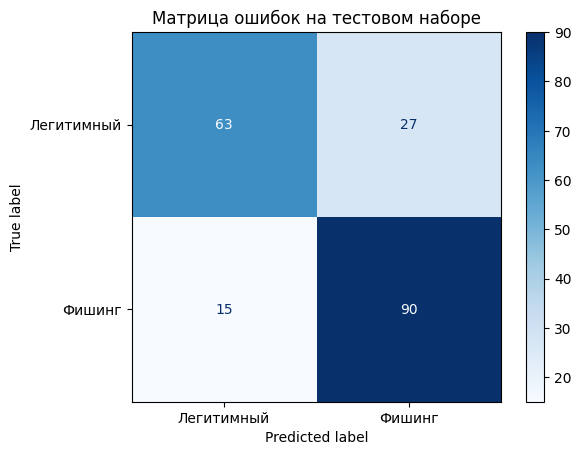

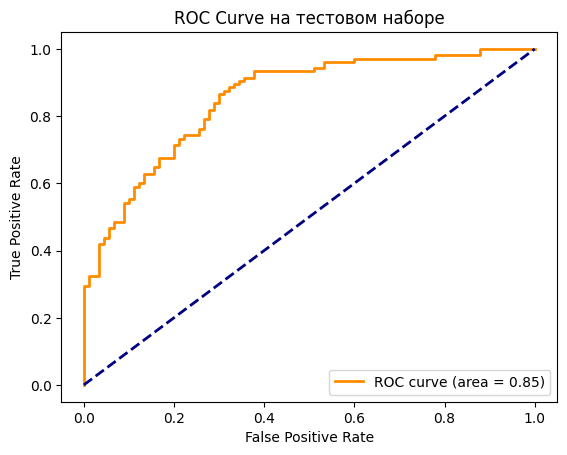

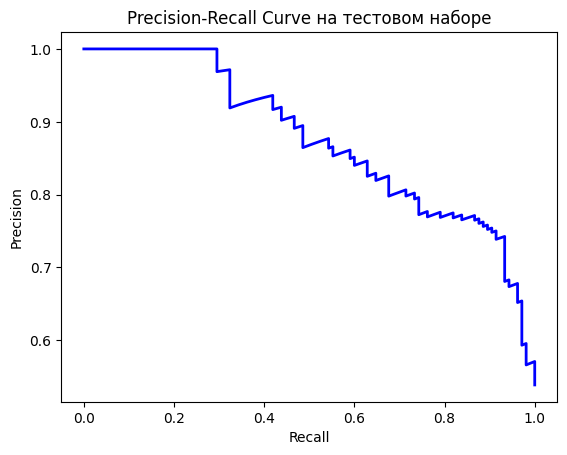

In [259]:


# Визуализация результатов
# Матрица ошибок
cm = confusion_matrix(y_test_encoded, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Легитимный', 'Фишинг'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок на тестовом наборе')
plt.show()

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test_encoded, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve на тестовом наборе')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_test_encoded, y_pred)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve на тестовом наборе')
plt.show()